In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

Populating the interactive namespace from numpy and matplotlib


In [2]:
def nonzero(wei):
    return tuple(np.nonzero(wei)[0])

def check_percent(bic_scores, complexities):
    slope = (bic_scores[1:]-bic_scores[:-1])/(complexities[1:]-complexities[:-1])
    slope_index = np.argmin(slope)
    percent_improve = 100*np.abs(bic_scores[slope_index+1]-bic_scores[slope_index])/np.abs(bic_scores[slope_index])
    percent_from_1 = 100*np.abs(bic_scores[slope_index+1]-bic_scores[0])/np.abs(bic_scores[0])
    return slope_index+1, percent_improve, percent_from_1

def percent_coeff(pred, ground):
    return 100*(np.abs(pred-ground)/np.abs(ground))

In [3]:
U = np.load('../Datasets/course_timestep_cylinder/Cylinder_U.npy')
V = np.load('../Datasets/course_timestep_cylinder/Cylinder_V.npy')
W = np.load('../Datasets/course_timestep_cylinder/Cylinder_W.npy')

dt = 0.2
dx = 0.02
dy = 0.02

In [4]:
xmin = 100
xmax = 425
ymin = 15
ymax = 185

x = (np.arange(449)*dx)[xmin:xmax]
y = (np.arange(199)*dy)[ymin:ymax]
t = np.arange(151)*dt

W = W[xmin:xmax,ymin:ymax,:]
U = U[xmin:xmax,ymin:ymax,:]
V = V[xmin:xmax,ymin:ymax,:]

In [5]:
def col_vec(vec): return vec.reshape(-1, 1)

In [6]:
fd = ps.SmoothedFiniteDifference(axis=-1)
wt = fd._differentiate(W, t=t).reshape(-1, 1)

fd = ps.SmoothedFiniteDifference(axis=0)
wx = fd._differentiate(W, t=x)
wxx = fd._differentiate(wx, t=x)
fd = ps.SmoothedFiniteDifference(axis=1)
wy = fd._differentiate(W, t=y)
wyy = fd._differentiate(wy, t=y)
wxy = fd._differentiate(wx, t=y)

fd = ps.SmoothedFiniteDifference(axis=-1)
wt = fd._differentiate(W, t=t).reshape(-1, 1)

w = col_vec(W)
u = col_vec(U)
v = col_vec(V)
wt = col_vec(wt)
wx = col_vec(wx)
wy = col_vec(wy)
wxx = col_vec(wxx)
wxy = col_vec(wxy)
wyy = col_vec(wyy)

In [7]:
theta = np.hstack([w, u, v, wx, wy, wxx, wxy, wyy])

In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(interaction_only=True, include_bias=False)
theta = poly_transformer.fit_transform(theta)
basis_names = ['w', 'u', 'v', 'w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
description = [''.join([basis_names[int(e)] for e in fn.replace('x', '').split()]) for fn in poly_transformer.get_feature_names_out()]

In [9]:
# Form Theta using up to quadratic polynomials in all variables.
# X_data = np.hstack([w,u,v])
# X_ders = np.hstack([np.ones((w.shape[0],1)), wx, wy, wxx, wxy, wyy])
# X_ders_descr = ['','w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
# X, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['w','u','v'])

In [10]:
lrs = []
ebics = []
eff_indices = []
max_complexity = 10
for s in range(1, max_complexity):
    lr = LinearRegression(support_size=s, ic_type='bic', always_select=None)
    lr.fit(theta, wt)
    lrs.append(lr)
    eff_indices.append(nonz(lr.coef_))
    ebics.append(lr.ic_)
    print(nonz(lr.coef_))
    print(lr.ic_)
abess_feature_hierarchy = set(eff_indices)

(3,)
-22756481.79869665
(3, 22)
-23900992.342734784
(7, 16, 22)
-49397232.076707594
(5, 7, 16, 22)
-52873990.62114105
(2, 5, 7, 16, 22)
-54806790.22714589
(2, 5, 7, 15, 16, 22)
-55178672.09783288
(2, 5, 7, 13, 15, 16, 22)
-55340928.83784835
(5, 7, 15, 16, 22, 24, 26, 28)
-55858475.88903728
(2, 5, 7, 15, 16, 22, 24, 26, 28)
-56784891.6495166


In [11]:
br1 = backward_refinement(abess_feature_hierarchy, (theta, wt), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(abess_feature_hierarchy, (theta, wt), mode='k best', ic_type='bic', verbose=True)
br_u=br1+br2; br_u

RFE_PLinearRegression
(5, 7, 15, 16, 22, 24, 26, 28)
(5, 7, 15, 16, 22, 24, 28)
(5, 7, 16, 22, 24, 28)
(5, 7, 16, 22, 24)
(5, 7, 16, 22)
(7, 16, 22)
(16, 22)
(16,)
--------------------------------------------------
(3, 22)
(3,)
--------------------------------------------------
(2, 5, 7, 15, 16, 22, 24, 26, 28)
(2, 5, 7, 16, 22, 24, 26, 28)
(2, 5, 7, 16, 22, 24, 28)
(2, 5, 7, 16, 22, 28)
(2, 5, 7, 16, 22)
(5, 7, 16, 22)
--------------------------------------------------
(2, 5, 7, 13, 15, 16, 22)
(2, 5, 7, 15, 16, 22)
(2, 5, 7, 16, 22)
--------------------------------------------------
(2, 5, 7, 16, 22)
--------------------------------------------------
(5, 7, 16, 22)
--------------------------------------------------
(2, 5, 7, 15, 16, 22)
--------------------------------------------------
(7, 16, 22)
--------------------------------------------------
SelectKBest
(5, 7, 15, 16, 22, 24, 26, 28)
(5, 7, 15, 16, 22, 24, 28)
(5, 7, 16, 22, 24, 28)
(5, 7, 16, 22, 24)
(5, 7, 16, 22)
(7, 16, 22

{1: ((3,), 6701971.368732434), 2: ((16, 22), -8899707.81245153), 3: ((7, 16, 22), -19938776.68029077), 4: ((5, 7, 16, 22), -23415533.17342277), 5: ((2, 5, 7, 16, 22), -25348336.844904445), 6: ((2, 5, 7, 15, 16, 22), -25720216.463609237), 7: ((2, 5, 7, 16, 22, 24, 28), -26705352.991840046), 8: ((2, 5, 7, 16, 22, 24, 26, 28), -26997442.985712484), 9: ((2, 5, 7, 15, 16, 22, 24, 26, 28), -27326435.69842902)}

In [12]:
complexities = np.array(sorted(list(br_u.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br_u.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(3,) 6701971.368732434
(16, 22) -8899707.81245153
(7, 16, 22) -19938776.68029077
(5, 7, 16, 22) -23415533.17342277
(2, 5, 7, 16, 22) -25348336.844904445
(2, 5, 7, 15, 16, 22) -25720216.463609237
(2, 5, 7, 16, 22, 24, 28) -26705352.991840046
(2, 5, 7, 16, 22, 24, 26, 28) -26997442.985712484
(2, 5, 7, 15, 16, 22, 24, 26, 28) -27326435.69842902


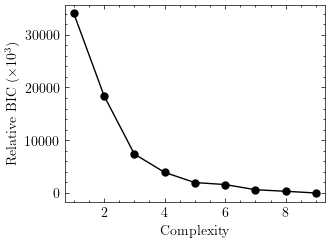

In [13]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()